In [1]:
import pandas as pd
import manager as m
from openai_textgen import TextGenerator
from datamodel import Goal
from datamodel import Summary, Persona

llm_config = {"n":1, 'max_tokens':2000, "temperature": 0, }
text_gen = TextGenerator()

In [2]:
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
nlviz = m.Manager(text_gen=text_gen, data=df)
data_summary = nlviz.summarize(textgen_config=llm_config, summary_method="llm")

# Suggest questions to ask based on dataset

In [3]:
display(Summary(**data_summary))


## Dataset Summary

---

**Name:** Bank Transactions

**File Name:** 

**Dataset Description:**

A dataset containing bank transactions

**Fields:**

- **Date:** {'column': 'Date', 'properties': {'dtype': 'date', 'min': '2023-08-01', 'max': '2023-11-01', 'samples': ['2023-09-10', '2023-08-23', '2023-09-25'], 'num_unique_values': 93, 'semantic_type': 'date', 'description': 'The date of the transaction'}}
- **Account_Number:** {'column': 'Account_Number', 'properties': {'dtype': 'number', 'std': 0, 'min': 1012345678, 'max': 1012345679, 'samples': [1012345679, 1012345678], 'num_unique_values': 2, 'semantic_type': 'account_number', 'description': 'The account number associated with the transaction'}}
- **Transaction_Type:** {'column': 'Transaction_Type', 'properties': {'dtype': 'category', 'samples': ['ACH', 'Transfer'], 'num_unique_values': 6, 'semantic_type': 'transaction_type', 'description': 'The type of transaction'}}
- **Transaction_Purpose:** {'column': 'Transaction_Purpose', 'properties': {'dtype': 'category', 'samples': ['Bills & utilities', 'Investment'], 'num_unique_values': 16, 'semantic_type': 'transaction_purpose', 'description': 'The purpose of the transaction'}}
- **Transaction_Amount:** {'column': 'Transaction_Amount', 'properties': {'dtype': 'number', 'std': 67302.40037054197, 'min': -120000.0, 'max': 250000.0, 'samples': [-85.0, -320.5], 'num_unique_values': 69, 'semantic_type': 'transaction_amount', 'description': 'The amount of the transaction'}}
- **Transaction_Description:** {'column': 'Transaction_Description', 'properties': {'dtype': 'string', 'samples': ["POS PURCHASE #2468 BARRY'S BOOTCAMP PACKAGE SF", 'ACH DEBIT LEGAL FEES FOR HEDGE FUND A CONSULTATION'], 'num_unique_values': 68, 'semantic_type': 'transaction_description', 'description': 'The description of the transaction'}}


In [4]:
from datamodel import Persona
persona= Persona(persona="A highly skilled data analyst who can come up with complex, insightful goals about data",rationale="")
goals = nlviz.goals(
        summary=data_summary,
        textgen_config=llm_config,
        n = 3,
        persona=persona)

for g in goals:
    display(g)


### Goal 0
---
**Question:** What is the distribution of transaction amounts?

**Visualization:** `histogram of Transaction_Amount`

**Rationale:** This visualization will show the frequency and range of transaction amounts, allowing us to understand the distribution of transaction amounts in the dataset. This can help identify any outliers or patterns in the transaction amounts.



### Goal 1
---
**Question:** What are the most common transaction types?

**Visualization:** `bar chart of Transaction_Type`

**Rationale:** By visualizing the transaction types in a bar chart, we can easily identify the most common transaction types. This can provide insights into the most frequently occurring transaction types and help identify any trends or patterns in the data.



### Goal 2
---
**Question:** What is the distribution of transaction purposes?

**Visualization:** `bar chart of Transaction_Purpose`

**Rationale:** By visualizing the transaction purposes in a bar chart, we can understand the distribution of transaction purposes. This can help identify the most common transaction purposes and provide insights into the different categories of transactions in the dataset.


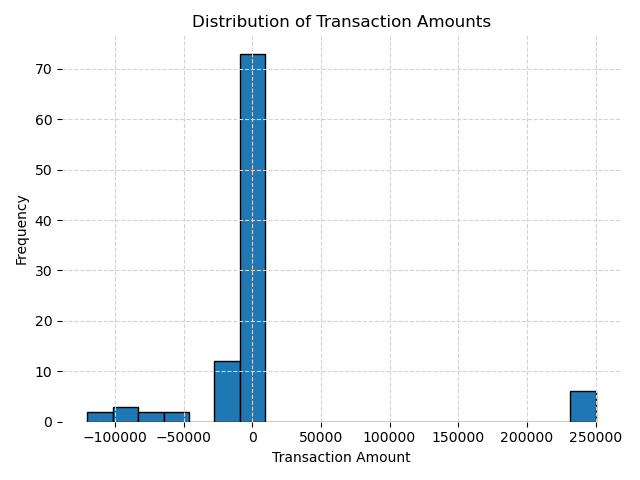

In [5]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[0], textgen_config=llm_config, return_error=True)
charts[0]

In [8]:
print(charts[0].code)

import matplotlib.pyplot as plt
import pandas as pd

# plan -
def plot(data: pd.DataFrame):
    plt.hist(data['Transaction_Amount'], bins=20, edgecolor='black')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency')
    plt.title('Distribution of Transaction Amounts')
    return plt

chart = plot(data)


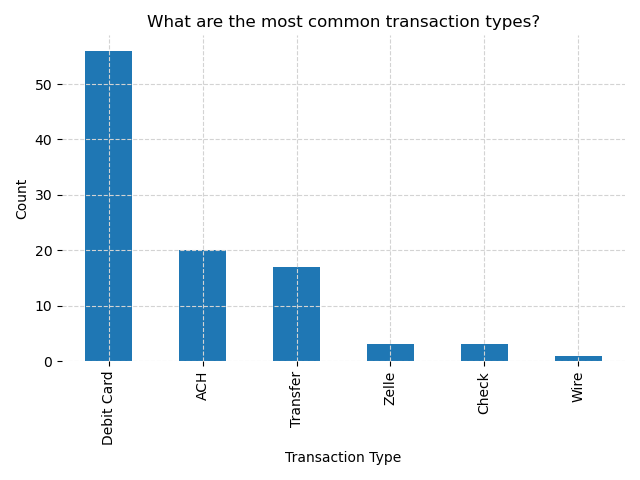

In [9]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[1], textgen_config=llm_config, return_error=True)
charts[0]

In [10]:
print(charts[0].code)

import matplotlib.pyplot as plt
import pandas as pd

# plan -
def plot(data: pd.DataFrame):
    transaction_types = data['Transaction_Type'].value_counts().sort_values(ascending=False)
    transaction_types.plot(kind='bar')
    plt.xlabel('Transaction Type')
    plt.ylabel('Count')
    plt.title('What are the most common transaction types?', wrap=True)
    return plt

chart = plot(data)


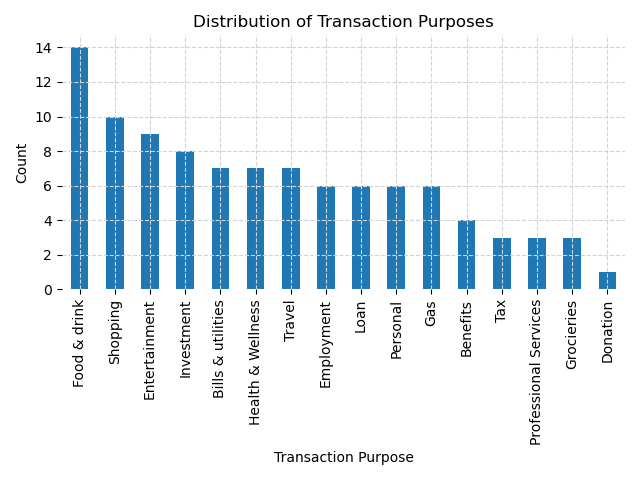

In [11]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[2], textgen_config=llm_config, return_error=True)
charts[0]

In [12]:
print(charts[0].code)

import matplotlib.pyplot as plt
import pandas as pd

# plan -
def plot(data: pd.DataFrame):
    transaction_purpose_counts = data['Transaction_Purpose'].value_counts()
    transaction_purpose_counts.plot(kind='bar')
    
    plt.xlabel('Transaction Purpose')
    plt.ylabel('Count')
    plt.title('Distribution of Transaction Purposes')
    
    return plt

chart = plot(data)


# Generate plots based on user questions

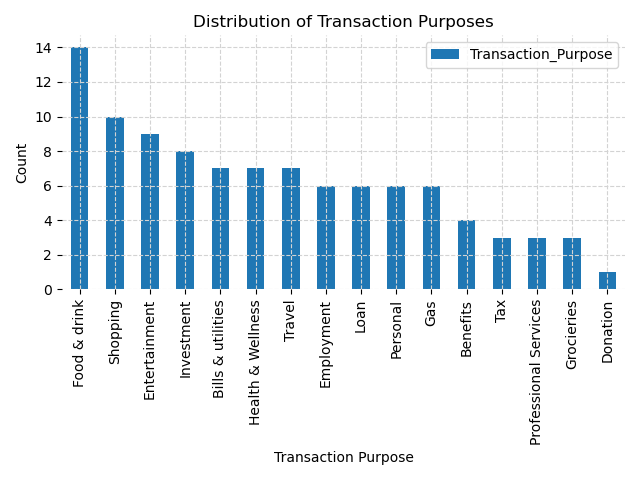

In [13]:
question = "what is the distribution of transaction purposes ?"
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

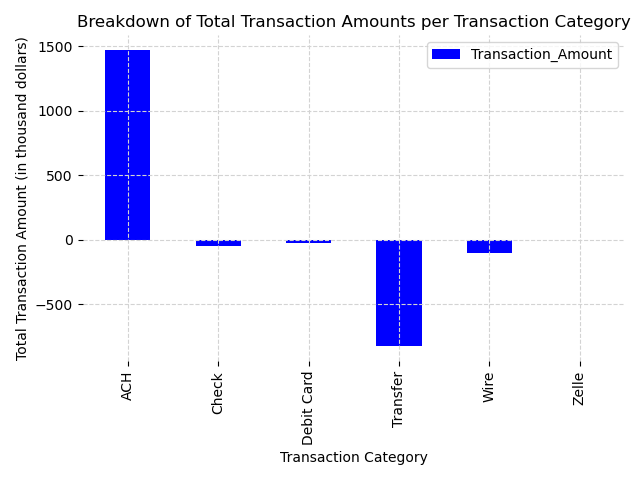

In [14]:
question = "What is the break down of total transaction amounts (in thousand dollars) per transaction category?"
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

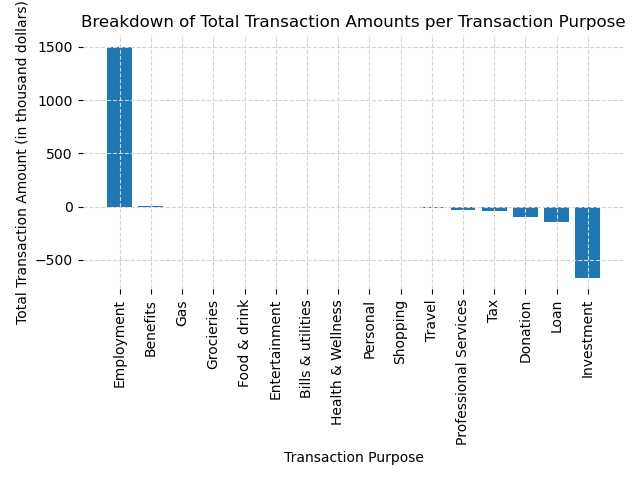

In [15]:
question = "What is the break down of total transaction amounts (in thousand dollars) per transaction purpose?"
viz_spces = "Avoid labels in the plot and rotate x labels by 90 degrees"
goal = Goal(question=question, visualization=viz_spces, rationale="")
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goal, textgen_config=llm_config, return_error=True)
charts[0]

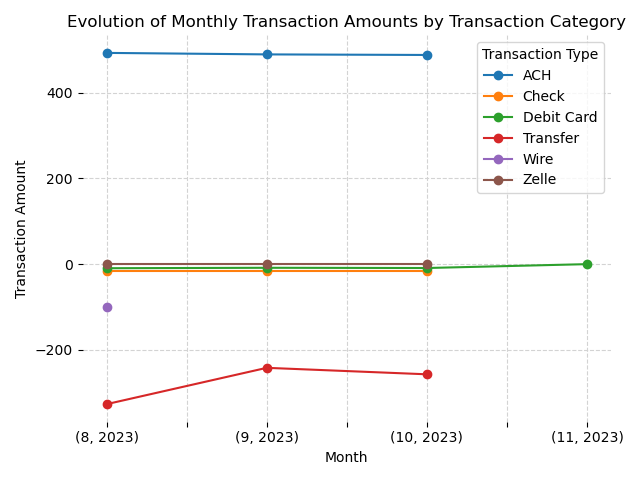

In [16]:
question = "show the evolution of monthly transaction amounts over time, broken down by transaction category"
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

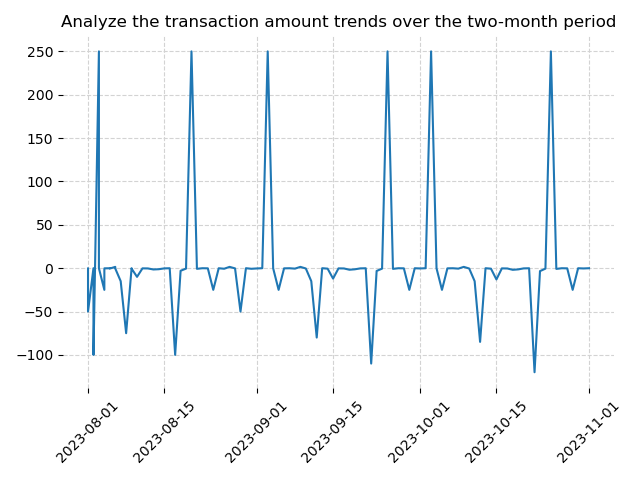

In [18]:
question = "analyze the transaction amount trends over the two-month period. (rotate the x labels)"
# viz_specs = "stacked bar chart"
# goal = Goal(question=question, visualization=viz_spces, rationale="")
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]